# **Tracking Penguin in Antarctica**


> Modified October 2024

### Overview

In this exercise, you will learn how to extract satellite data in polar stereographic projection (defined by xgrid and ygrid) around a set of points specified by longitude, latitude, and time coordinates. These coordinates could represent data from animal telemetry tags, ship tracks, or glider tracks.


#### The exercise demonstrates the following techniques:

* Loading animal telemetry tags data from tab- or comma-separated files
* Extracting satellite data along a track
* Plotting animal tracks and satellite data on a map

### Datasets Used:
**Sea Ice Concentration Satellite Data**  

This dataset contains daily and monthly Climate Data Records (CDR) of sea ice concentration, processed by the NOAA/NSIDC team for the Arctic at a 25 km resolution, spanning from 1978 to the most recent annual data processing update. The sea ice concentration data are derived from microwave remote sensing. Due to processing and quality control, CDR data has a slight delay in availability, but [near real-time data is available for more recent dates.](https://polarwatch.noaa.gov/catalog/ice-sq-sh-nsidc-cdr-v4/preview).

For this tutorial, the monthly sea ice concentration data is used. To preview and download CDR data, [visit NOAA PolarWatch CDR Data](https://polarwatch.noaa.gov/catalog/ice-sq-sh-nsidc-cdr-v4/preview/?).



**Adelie Penguin Telemetry Track** 

Telemetry data from Adelie penguins (_Pygoscelis adeliae_) were collected via Argos satellites in the Southern Ocean between October 29, 1996, and February 19, 2013, as part of the U.S. Antarctic Marine Living Resources project. Additionally, a turtle raised in captivity in Japan was tagged and released on May 4, 2005, in the Central Pacific.  

The telemetry track dataset is included in the data/ folder of this module. For more information about the project and to download the full dataset, visit the [NOAA NCEI webpage](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0244399).
 

## Import the required Python modules

## Packages

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs  
import cartopy.feature as cfeature
import warnings
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
warnings.filterwarnings("ignore")

### Loading the sea ice data from PolarWatch ERDDAP


In [41]:
# Get sea ice data by sending data request using xarray to ERDDAP using its unique ID 'nsidcG02202v4shmday'
ds = xr.open_dataset("https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday")




In [69]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                           (time: 545, ygrid: 332, xgrid: 316)
Coordinates:
  * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
  * ygrid                             (ygrid) float32 1kB 4.338e+06 ... -3.93...
  * xgrid                             (xgrid) float32 1kB -3.938e+06 ... 3.93...
Data variables:
    cdr_seaice_conc_monthly           (time, ygrid, xgrid) float32 229MB ...
    nsidc_bt_seaice_conc_monthly      (time, ygrid, xgrid) float32 229MB ...
    nsidc_nt_seaice_conc_monthly      (time, ygrid, xgrid) float32 229MB ...
    qa_of_cdr_seaice_conc_monthly     (time, ygrid, xgrid) float32 229MB ...
    stdev_of_cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 229MB ...
Attributes: (12/66)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2024-03-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

### Plotting Sea Ice Data on a Map

Text(0.5, 1.0, 'Ice Concentration of timestep 1')

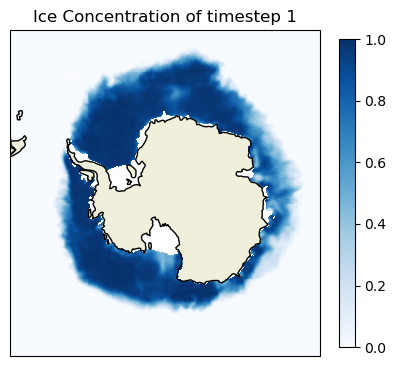

In [50]:
# Select sea ice concentration variable of first timestep
sic = ds['cdr_seaice_conc_monthly'][0]

# Based on the metadata, values above 1 represent variouag flags, therefore we will 
# remove the values greater than 1.
sic = sic.where(sic <=1, np.nan)

# Set coordinate reference system (crs) based on the projection attribute from ds
polar_crs = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=-70)

# Set figure size
plt.figure(figsize=(5,5))

# Set the map projection and associated boundaries based on the metadata
ax = plt.axes(projection = polar_crs)
ax.set_extent([-3950000.0, 3950000.0, -3950000.0, 4350000.0], polar_crs)  
ax.coastlines()
ax.add_feature(cfeature.LAND)

# Plot first time-step
cs = ax.pcolormesh(ds['xgrid'], ds['ygrid'], sic,
                   cmap=plt.cm.Blues,  transform= polar_crs) #transform default is basemap specs
plt.colorbar(cs, ax=ax, location='right', shrink =0.8)
ax.set_title('Ice Concentration of timestep 1')

### Loading penguin telemetry data in csv 

In [46]:
# Load penguin data into pandas data frame
penguin = pd.read_csv('data/copa_adpe_ncei.csv')
penguin.head()

,BirdId,Sex,Age,Breed Stage,DateGMT,TimeGMT,Latitude,Longitude,ArgosQuality
0,ADPE1,female,adult,incubation,28/10/1997,7:54:00,-62.171667,-58.445000,2
1,ADPE1,female,adult,incubation,28/10/1997,9:32:00,-62.173333,-58.463333,2
2,ADPE1,female,adult,incubation,28/10/1997,18:15:00,-62.158333,-58.426667,1
3,ADPE1,female,adult,incubation,28/10/1997,19:57:00,-62.175000,-58.441667,2
4,ADPE1,female,adult,incubation,28/10/1997,21:37:00,-62.171667,-58.445000,2


### Processing Penguin Data

For this exercise, we will select ADPE24, female penguin whose track records are highest within the female group, and will follow her 
journey in the Arctic.

In [51]:
# Find BirdID with the most count by sex
penguin.groupby('Sex')['BirdId'].apply(lambda x: x.value_counts().idxmax())

# Extract ADPE24 track data
adpe24 = penguin[penguin['BirdId']=='ADPE24']

# Format Date
adpe24['DateGMT'] = pd.to_datetime(adpe24['DateGMT'], format='%d/%m/%Y')
adpe24['Year_Month'] = adpe24['DateGMT'].dt.strftime('%Y-%m')

# unique penguin dates
adpe_dates = adpe24['Year_Month'].unique()

print(f"Date Range: {adpe24['DateGMT'].min()}, {adpe24['DateGMT'].max()}")
print(f"Unique Month: {adpe24['Year_Month'].unique()}")


Date Range: 2003-01-16 00:00:00, 2003-03-09 00:00:00
Unique Month: ['2003-01' '2003-02' '2003-03']


### Visualize penguin tracks on sea ice concentration map


In [53]:
adpe_dates

array(['2003-01', '2003-02', '2003-03'], dtype=object)

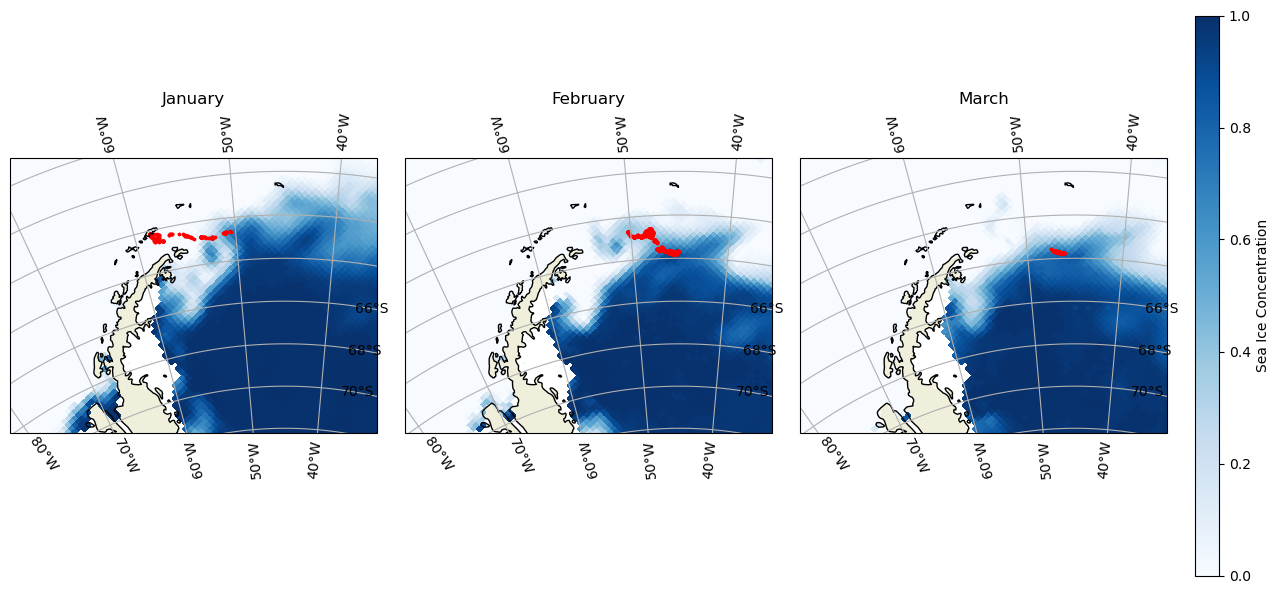

In [63]:
# Subset sea ice data based on ADPE24 unique dates
ds_penguin = ds.sel(time=adpe_dates, method='nearest')
# Process sea ice data
sic_penguin = ds_penguin['cdr_seaice_conc_monthly']
sic_penguin = sic_penguin.where(sic_penguin <=1, np.nan)


# Penguin Data for Each Month
adpe24_jan = adpe24[adpe24['DateGMT'].dt.month == 1]
adpe24_feb = adpe24[adpe24['DateGMT'].dt.month == 2]
adpe24_mar = adpe24[adpe24['DateGMT'].dt.month == 3]

adpe24_data = [adpe24_jan, adpe24_feb, adpe24_mar]
titles = ['January', 'February', 'March']

# set mapping crs to Cartopy's South Polar Stereo graphic
crs_epsg = ccrs.SouthPolarStereo(central_longitude=-45)

# Assuming your setup is the same
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), subplot_kw={'projection': crs_epsg})

for i, ax in enumerate(axes):
    # set basemap with Cartopy PlateCarree() projection
    ax.add_feature(cfeature.LAND)
    ax.coastlines(resolution='50m')
    ax.set_extent([-1500000.0, 500000.0, 2000000.0, 3500000.0], crs_epsg)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=True)

    cs = ax.pcolormesh(ds_penguin['xgrid'], ds_penguin['ygrid'], sic_penguin[i],
                       cmap=plt.cm.Blues, transform=ccrs.SouthPolarStereo(true_scale_latitude=-70, central_longitude=0))

    # set the data crs
    ax.scatter(
        y=adpe24_data[i]["Latitude"],
        x=adpe24_data[i]["Longitude"],
        color="red",
        s=3,
        alpha=1,
        transform=ccrs.PlateCarree()
    )

    ax.set_title(titles[i])

 #Create a colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]  
fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label='Sea Ice Concentration')

plt.tight_layout()
plt.show()
     

### Resampling Penguin data to match satellite Date


In [64]:

adpe24 = adpe24[["DateGMT", "Latitude", "Longitude"]]
adpe24['DateGMT'] = pd.to_datetime(adpe24['DateGMT'], format='%d/%m/%Y')
adpe24_df = adpe24.resample('D', on='DateGMT').mean()


### Transforming CRS of the penguin locations

In [74]:

latlon_crs = ccrs.PlateCarree() # lat and lon
polar_crs = ccrs.epsg('3412') # South pole

transformed_coords = polar_crs.transform_points(latlon_crs, adpe24_df['Longitude'].values, adpe24_df['Latitude'].values)

adpe24_df['xgrid'] = transformed_coords[:, 0]
adpe24_df['ygrid'] = transformed_coords[:, 1]

adpe24_df.head()

,Latitude,Longitude,erddap_date,matched_ygrid,matched_xgrid,matched_sea_ice_concen,xgrid,ygrid
DateGMT,,,,,,,,
2003-01-16,-62.177000,-58.452600,NaN,NaN,NaN,NaN,-2.618256e+06,1.607450e+06
2003-01-17,-62.176370,-58.425000,NaN,NaN,NaN,NaN,-2.617543e+06,1.608749e+06
2003-01-18,-62.339500,-57.683400,NaN,NaN,NaN,NaN,-2.580691e+06,1.632492e+06
2003-01-19,-62.547353,-57.539765,NaN,NaN,NaN,NaN,-2.556494e+06,1.626173e+06
2003-01-20,-62.163853,-58.457471,NaN,NaN,NaN,NaN,-2.619678e+06,1.608017e+06


### Extracting Satellite Data to match penguin track and date

In [76]:

# Add new columns to the dataframe
adpe24_df[["erddap_date", "matched_ygrid", "matched_xgrid", "matched_sea_ice_concen"]] = np.nan

# Subset the satellite data
for i in range(0, len(adpe24_df)):
    # Download the satellite data
    temp_ds = ds['cdr_seaice_conc_monthly'].sel(time='{0:%Y-%m-%d}'.format(adpe24_df.index[i]),
                                ygrid=adpe24_df.iloc[i]['ygrid'],
                                xgrid=adpe24_df.iloc[i]['xgrid'],
                                method='nearest'
                                )
    
    # Add to the dataframe
    adpe24_df.loc[adpe24_df.index[i], ["erddap_date", "matched_ygrid",
                                 "matched_xgrid", "matched_sea_ice_concen"]
          ] = [temp_ds.time.values,
               np.round(temp_ds.ygrid.values, 5),  # round 5 dec
               np.round(temp_ds.xgrid.values, 5), # round 5 dec
               np.round(temp_ds.values, 2)  # round 2 decimals
               ]

### Plotting Penguin Tracks with Matched Sea Ice Concentration Data

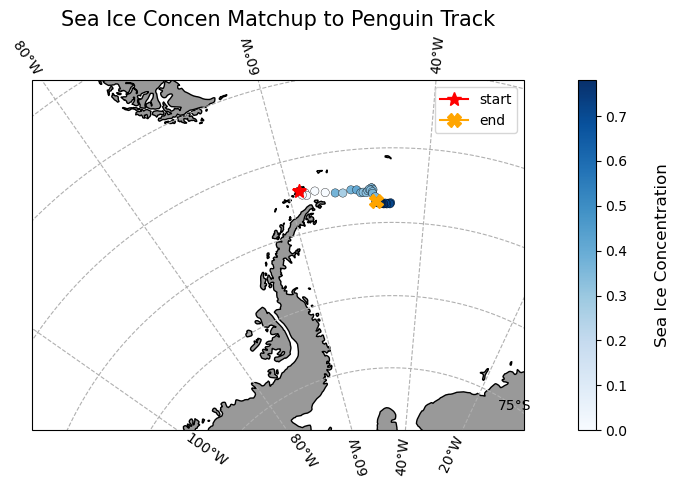

In [78]:
plt.figure(figsize=(14, 10))


# set the projection
ax1 = plt.subplot(211, projection=crs_epsg)

# Use the lon and lat ranges to set the extent of the map
ax1.set_extent([-90, -30, -75, -55], ccrs.PlateCarree()) # South Pole

# Add grid line
gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# build and plot coordinates onto map
x,y = list(adpe24_df.Longitude), list(adpe24_df.Latitude)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=adpe24_df.matched_sea_ice_concen,
                  cmap=plt.get_cmap('Blues'),
                  edgecolor='Black',
                  linewidth=0.25
                  )
ax1=plt.plot(x[0],y[0],marker='*', label='start', color='red', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', label='end',color='orange', transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
levs2 = np.arange(0, 1, 0.1)

cbar=plt.colorbar()
cbar.set_label("Sea Ice Concentration", size=12, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.round(levs2, 1), size=10)

plt.legend()
plt.title("Sea Ice Concen Matchup to Penguin Track", size=15)
plt.show()
     
